# EEG Analysis Notebook — PhysioNet (Motor Movement/Imagery) + CHB-MIT (seizure detection)

Este notebook 2 blocos principais:
1) Pipeline com o dataset *EEG Motor Movement/Imagery* (PhysioNet / BCI2000) cobrindo:
 - leitura e pré-processamento (filtragem, notch)
 - PSD / bandpower por banda + topomapas
 - espectrograma (STFT) e scalogram (CWT)
 - ICA: identificação e remoção de artefatos (ex.: piscadas)
 - ERP / média por evento (quando aplicável)
 2) Notebook curto para detecção de crises (CHB-MIT):
 - leitura de EDFs (exige download manual ou upload para Colab)
 - extração de features (bandpower, entropia, RMS)
 - classificação simples (RandomForest) em janelas

 Cite: Este notebook usa MNE-Python para manipulação de EEG, PyWavelets para CWT e scikit-learn para ML.





In [29]:
#  0) Instalação das dependências

!pip install mne==1.4.2 pyedflib pywavelets scikit-learn matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# 1) Importação de bibliotecas

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import mne
from mne.time_frequency import psd_array_welch
PSD_FUNC = psd_array_welch
from mne.preprocessing import ICA, create_eog_epochs
from mne.channels import make_standard_montage


import pywt
from scipy.signal import spectrogram


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report


print('mne version:', mne.__version__)

mne version: 1.4.2


Extracting EDF parameters from c:\Users\guilh\Downloads\signal.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5110783  =      0.000 ...  9981.998 secs...
Reading 0 ... 5110783  =      0.000 ...  9981.998 secs...

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG F7, EEG T3, EEG T5, ...
 chs: 45 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2017-01-01 05:40:05 UTC
 nchan: 45
 projs: []
 sfreq: 512.0 Hz
>

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG F7, EEG T3, EEG T5, ...
 chs: 45 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2017-01-01 05:40:05 UTC
 nchan: 45
 projs: []
 sfreq: 512.0 Hz
>


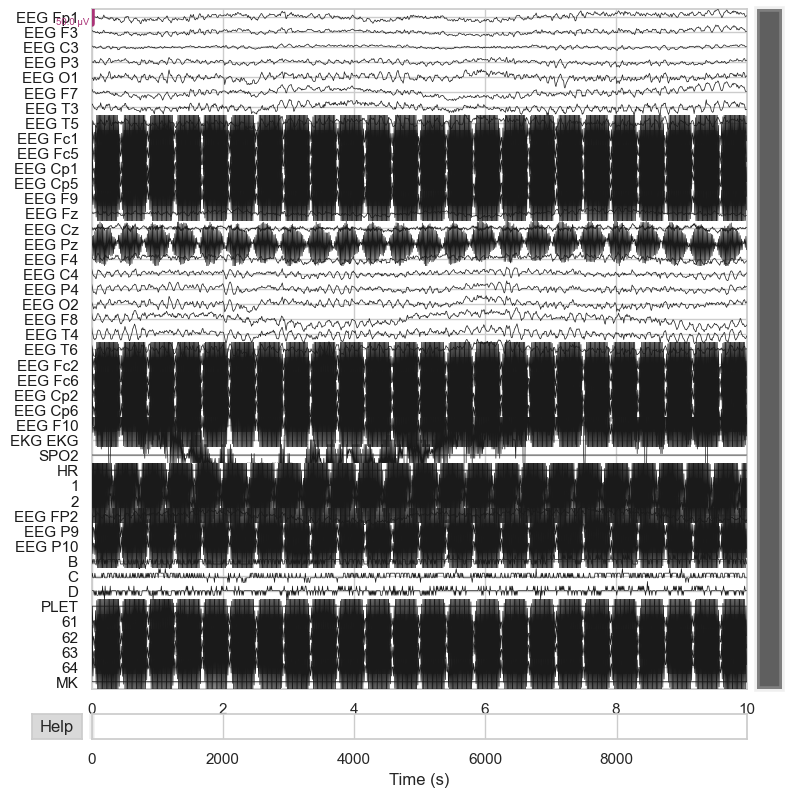

In [31]:
## 📥 Load EEG Data from PhysioNet

# 1. Defina a URL exata de DOWNLOAD DIRETO
file_url = 'https://physionet.org/files/siena-scalp-eeg/1.0.0/PN10/PN10-1.edf'
local_file_name = 'signal.edf'

# 2. Baixa o arquivo da URL (apenas se ele ainda não existir nesta sessão)
# if not os.path.exists(local_file_name):
#     print(f'Baixando arquivo de {file_url}...')
#     !wget -q -O {local_file_name} {file_url}
#     print('Download completo.')
# else:
#     print(f'O arquivo {local_file_name} já existe.')
# print()

# 3. Carrega o arquivo .edf (o binário real) que acabamos de baixar
raw = mne.io.read_raw_edf(local_file_name, preload=True)
original_signal = raw.copy()

# 4. Informações básicas
print()
print(original_signal.info)
original_signal.plot(duration=10, n_channels=45, scalings=25e-6, show=True)
None

In [ ]:
## 🧹 Preprocessing and Filtering

original_signal.load_data()

# Filtro passa-banda (tipicamente 1–40 Hz EEG)
# Ajustando filtros conforme sugestões: high-pass entre 0.3-1 Hz e low-pass entre 70-100 Hz
# raw.filter(1., 40., fir_design='firwin') # Usando 0.5 Hz high-pass e 40 Hz low-pass
filter_signal = original_signal.copy().filter(l_freq=1.0, h_freq=None, fir_design='firwin')

# Correção da nomeclatura dos canais
channel_names = filter_signal.info['ch_names']
mapping = {name: name.replace('.', '').upper() for name in channel_names}
filter_signal.rename_channels(mapping)

# Artifact detection using ICA
n_channels = len(filter_signal.info['ch_names'])
n_components = 15

ica = ICA(n_components=n_components, max_iter="auto", random_state=97)
ica.fit(filter_signal.copy())
ica

print("Plotando as fontes (sinais) dos componentes ICA...")
ica.plot_sources(filter_signal.copy(), show_scrollbars=False)
None

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)

Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    9.1s finished


Fitting ICA to data using 45 channels (please be patient, this may take a while)
Selecting by number: 15 components
Selecting by number: 15 components


In [ ]:
# 🔎 Auto-limpeza de ICA: detecta e remove componentes com padrão de ruído (qualquer tipo)
# Pré-requisitos: 'ica' treinado e 'filter_signal' (mesmo sinal usado no fit do ICA)

import numpy as np
import re
from collections import defaultdict
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.time_frequency import psd_array_welch as _psd

inst = filter_signal  # garanta que seja o mesmo usado em ica.fit
sfreq = inst.info['sfreq']
n_comp = ica.n_components_

# 1) Normalização de nomes e detecção de canais frontais (para EOG)
def _norm(name: str) -> str:
    return re.sub(r'[^A-Z0-9]', '', name.upper().replace('EEG', ''))

norm_map = {_norm(c): c for c in inst.info['ch_names']}
frontal_targets = ['FP1', 'FP2', 'FPZ', 'AF7', 'AF8', 'F7', 'F8', 'F9', 'F10', 'F3', 'F4']
frontal_present = []
for tgt in frontal_targets:
    for key, orig in norm_map.items():
        if tgt in key and orig not in frontal_present:
            frontal_present.append(orig)

# 2) Fontes ICA (tempo) e PSD por componente
sources = ica.get_sources(inst).get_data()  # shape: (n_comp, n_times)
psd, freqs = _psd(sources, sfreq=sfreq, fmin=0.1, fmax=120.0, n_fft=4096)

# 3) Recursos/escores por componente
eps = 1e-20

# Bandas para heurísticas
hf = (freqs >= 30) & (freqs <= 90)     # alta frequência (EMG)
lf = (freqs >= 1) & (freqs < 15)       # baixa frequência (fundo neural)
beta = (freqs >= 13) & (freqs < 30)
very_low = (freqs >= 0.1) & (freqs <= 2.0)  # drift/ocular

line_freq = inst.info.get('line_freq', None)
line50 = (freqs >= 49) & (freqs <= 51)
line60 = (freqs >= 59) & (freqs <= 61)

hf_power = psd[:, hf].mean(axis=1) + eps
lf_power = psd[:, lf].mean(axis=1) + eps
beta_power = psd[:, beta].mean(axis=1) + eps
vl_power = psd[:, very_low].mean(axis=1) + eps
broad_power = psd.mean(axis=1) + eps

hf_lf_ratio = hf_power / lf_power              # EMG
slow_ratio = vl_power / (beta_power + hf_power)  # EOG/deriva
line50_ratio = (psd[:, line50].mean(axis=1) + eps) / broad_power
line60_ratio = (psd[:, line60].mean(axis=1) + eps) / broad_power

comp_std = sources.std(axis=1)  # componentes muito planos

# Topografia: peso médio em canais frontais (para apoiar EOG)
try:
    topos = ica.get_components()  # shape (n_channels, n_comp)
except Exception:
    topos = None

frontal_idx = [inst.ch_names.index(ch) for ch in frontal_present if ch in inst.ch_names]
frontal_load = np.zeros(n_comp)
if topos is not None and len(frontal_idx) > 0:
    frontal_load = np.abs(topos[frontal_idx, :]).mean(axis=0)

# 4) Detectores dedicados (EOG/ECG) do MNE
try:
    if frontal_present:
        eog_inds_mne, eog_scores_mne = ica.find_bads_eog(inst, ch_name=frontal_present[0])
    else:
        eog_inds_mne, eog_scores_mne = ica.find_bads_eog(inst)
except Exception:
    eog_inds_mne, eog_scores_mne = [], np.array([])

try:
    ecg_inds_mne, ecg_scores_mne = ica.find_bads_ecg(inst, method='correlation', threshold='auto')
except Exception:
    ecg_inds_mne, ecg_scores_mne = [], np.array([])

# 5) Seleção robusta baseada em z-score (mediana/MAD) e regras

def robust_z(x):
    x = np.asarray(x)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-20
    return (x - med) / (1.4826 * mad)

reasons = defaultdict(list)

# EMG: razão HF/LF alta
emg_z = robust_z(hf_lf_ratio)
for k in np.where(emg_z > 2.0)[0]:
    reasons[int(k)].append(f"EMG: z(HF/LF)={emg_z[k]:.2f}")

# Linha de energia: picos estreitos em 50/60 Hz
line50_z = robust_z(line50_ratio)
line60_z = robust_z(line60_ratio)
for k in np.where(line50_z > 3.0)[0]:
    reasons[int(k)].append(f"Linha 50Hz: z={line50_z[k]:.2f}")
for k in np.where(line60_z > 3.0)[0]:
    reasons[int(k)].append(f"Linha 60Hz: z={line60_z[k]:.2f}")

# Drift/EOG: potência muito baixa frequência, preferindo cargas frontais
slow_z = robust_z(slow_ratio)
frontal_thresh = np.quantile(frontal_load, 0.75) if frontal_load.size else 0.0
for k in np.where(slow_z > 2.0)[0]:
    if frontal_load.size == 0 or frontal_load[k] >= frontal_thresh:
        reasons[int(k)].append(
            f"Ocular/Drift: z(0.1–2Hz ratio)={slow_z[k]:.2f}, frontal_load={frontal_load[k]:.3f}")

# Planos/degenerados: desvio padrão muito baixo (quase nulo)
std_p5 = np.quantile(comp_std, 0.05)
for k in np.where(comp_std <= max(std_p5, 1e-12))[0]:
    reasons[int(k)].append(f"Plano: std={comp_std[k]:.2e}")

# Inclusão direta dos detectores MNE (EOG/ECG)
for k in (eog_inds_mne or []):
    reasons[int(k)].append("MNE EOG: correlação elevada")
for k in (ecg_inds_mne or []):
    reasons[int(k)].append("MNE ECG: correlação elevada")

# 6) Consolida e aplica exclusões
excluir = sorted(set([k for k in reasons.keys() if 0 <= k < n_comp]))

print("\nResumo de razões por componente marcado como ruído:")
if excluir:
    for k in excluir:
        print(f" - IC {k:03d}: " + "; ".join(reasons[k]))
else:
    print("Nenhum componente marcado — nenhum padrão de ruído detectado pelos critérios.")

ica.exclude = excluir

# 7) Aplica a limpeza ao mesmo sinal usado no fit
clean_signal = ica.apply(inst.copy())
print(f"\n✅ Limpeza concluída. Componentes excluídos: {excluir} (total={len(excluir)}) → 'clean_signal' atualizado.")

# 8) Opcional: visualizar mapas dos componentes excluídos
try:
    if len(excluir) > 0:
        ica.plot_components(picks=excluir)
except Exception:
    pass

None

Effective window size : 8.000 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Using EOG channel: EEG FP1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Resumo de razões por componente marcado como ruído:
 - IC 002: Linha 60Hz: z=3.08
 - IC 003: EMG: z(HF/LF)=20.02; Linha 50Hz: z=15.27; Plano: std=1.00e+00
 - IC 005: EMG: z(HF/LF)=4.04; Linha 60Hz: z=8.06
 - IC 008: EMG: z(HF/LF)=19.61; Linha 50Hz: z=14.94
 - IC 010: Ocular/Drift: z(0.1–2Hz ratio)=3.40, frontal_load=0.027
 - IC 012: Linha 60Hz: z=6.27
 - IC 013: EMG: z(HF/LF)=3.67; Linha 60Hz: z=10.54
 - IC 014: Linha 60Hz: z=10.44
Applying ICA to Raw instance
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    Projecting back using 45 PCA components
    Zeroing out 8 ICA components
    Projecting back using 45 PCA components



✅ Limpeza concluída. Componentes excluídos: [2, 3, 5, 8, 10, 12, 13, 14] (total=8) → 'clean_signal' atualizado.


| ICA               | Classificação                                    | Justificativa neurofisiológica                                                                                                                                                         |
| ----------------- | ------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **ICA000–ICA005** | **Ruído (componentes inativos ou de base)**      | Amplitude quase nula, ausência de oscilação rítmica — provavelmente componentes residuais do processo ICA sem relevância fisiológica.                                                  |
| **ICA006**        | **Onda cerebral (provável alfa-teta mista)**     | Oscilação regular, de amplitude moderada, contínua ao longo do tempo (~8–10 Hz). Caracteriza atividade cerebral coerente, possivelmente posterior ou teta frontal conforme topografia. |
| **ICA007**        | **Onda cerebral (atividade cortical estável)**   | Sinal rítmico e estável, sem picos abruptos nem artefatos musculares; morfologia consistente com atividade neural contínua (faixa teta–alfa).                                          |
| **ICA008**        | **Onda cerebral (teta ou alfa baixa)**           | Oscilação moderada, coerente, sem ruído de alta frequência. Provável atividade teta (4–7 Hz) ou alfa baixa (7–9 Hz).                                                                   |
| **ICA009**        | **Onda cerebral (atividade rápida fisiológica)** | Ritmo mais rápido (~12–15 Hz), coerente e de baixa amplitude — pode corresponder a ritmo sensório-motor (SMR).                                                                         |
| **ICA010**        | **Ruído (possível muscular)**                    | Traçado irregular, amplitude variável, presença de oscilações rápidas (>30 Hz) e ausência de ritmo biológico estável.                                                                  |
| **ICA011**        | **Ruído (possível muscular/fonte periférica)**   | Padrão de alta frequência, sem periodicidade — típico de artefato EMG.                                                                                                                 |
| **ICA012**        | **Ruído (movimento ou artefato misto)**          | Flutuações irregulares, ausência de ritmo dominante; aspecto espiculado sugere contaminação muscular ou movimento.                                                                     |
| **ICA013**        | **Ruído (alta frequência)**                      | Traçado denso e rápido, característica de ruído muscular ou elétrico, não de oscilação cortical.                                                                                       |
| **ICA014**        | **Ruído (artefato ocular ou movimento)**         | Padrão de grandes deflexões de baixa frequência (<2 Hz), típico de piscar ou movimento ocular.                                                                                         |



### Resumo:

**Prováveis artefatos a remover:**
- **ICA000–ICA005**: Ruído / componentes inativos (amplitude quase nula, sem oscilação rítmica)
- **ICA010**: Ruído muscular (traçado irregular, >30 Hz, sem ritmo biológico)
- **ICA011**: Ruído muscular / fonte periférica (alta frequência, sem periodicidade)
- **ICA012**: Movimento ou artefato misto (flutuações irregulares, aspecto espiculado)
- **ICA013**: Alta frequência / ruído muscular ou elétrico (traçado denso e rápido)
- **ICA014**: Artefato ocular ou movimento (grandes deflexões <2 Hz, típico de piscar)

**Prováveis sinais cerebrais úteis (manter):**
- **ICA006**: Onda cerebral alfa-teta mista (~8–10 Hz, oscilação regular e contínua)
- **ICA007**: Atividade cortical estável (ritmo teta–alfa, sem picos abruptos)
- **ICA008**: Teta ou alfa baixa (4–9 Hz, oscilação moderada e coerente)
- **ICA009**: Atividade rápida fisiológica (~12–15 Hz, possível ritmo sensório-motor)


Plotando o sinal ORIGINAL (raw):


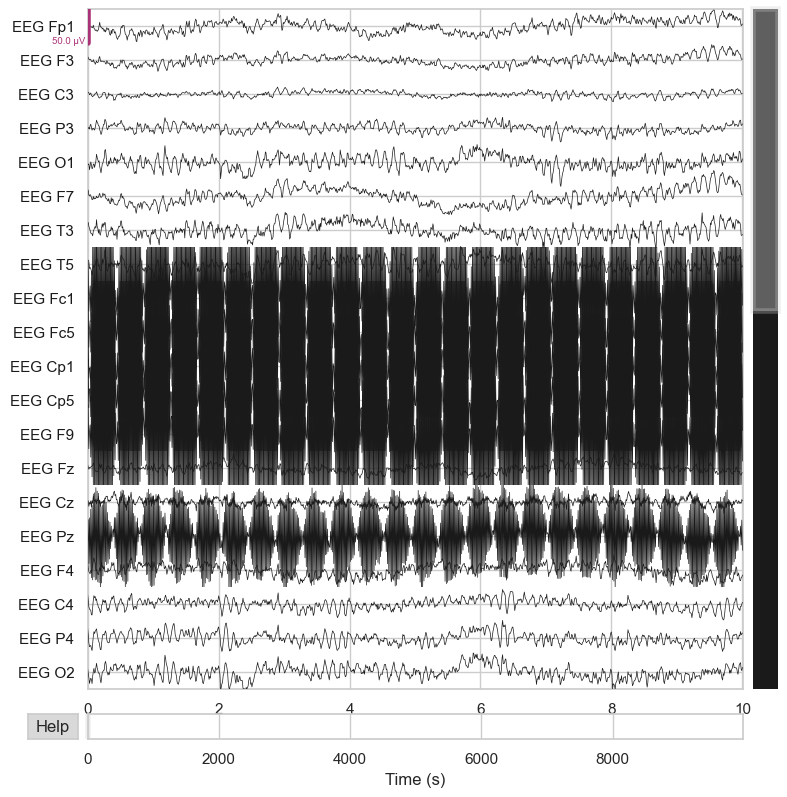


Plotando o sinal FILTRADO:


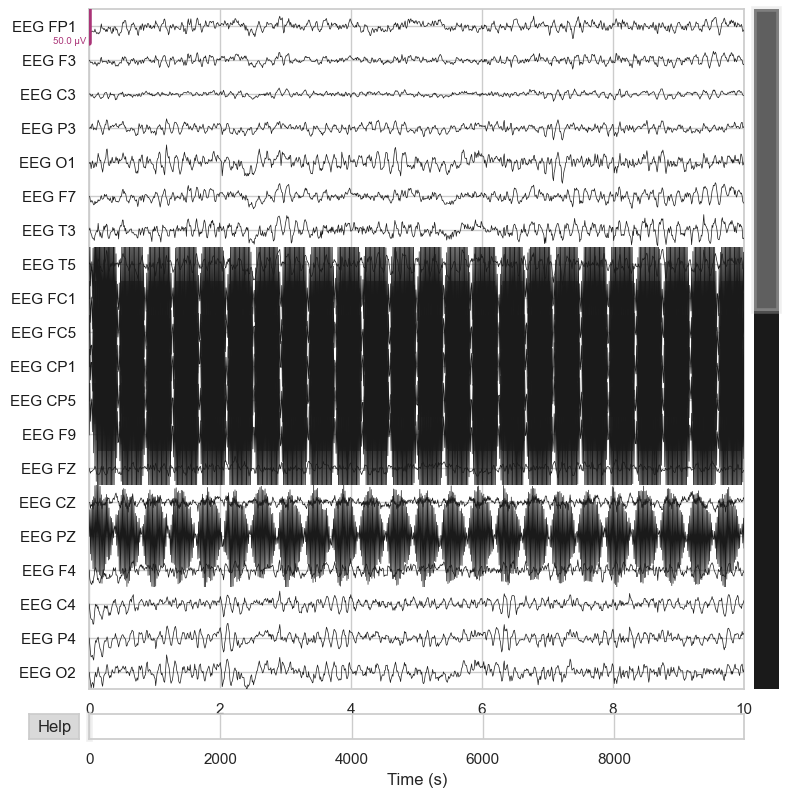


Plotando o sinal LIMPO:


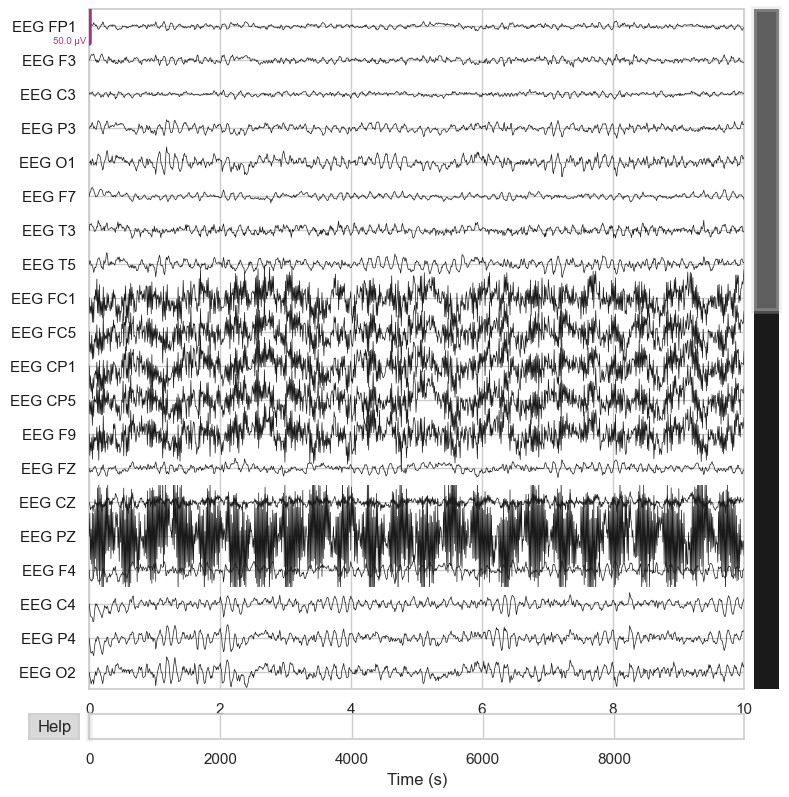

In [ ]:
# Sinal Com e Sem os Artefatos removidos (usando ICA)

# 4. Comparação do sinal original com o limpo
fixed_scaling = dict(eeg=25e-6)

print("Plotando o sinal ORIGINAL (raw):")
raw.plot(duration=10,
         n_channels=20,
         scalings=fixed_scaling,
         title='SINAL ORIGINAL (Escala 25µV)')

print()

print("Plotando o sinal FILTRADO:")
filter_signal.plot(duration=10,
         n_channels=20,
         scalings=fixed_scaling,
         title='SINAL FILTRADO (Escala 25µV)')

print()

print("Plotando o sinal LIMPO:")
clean_signal.plot(duration=10,
               n_channels=20,
               scalings=fixed_scaling,
               title='SINAL LIMPO (Escala 25µV)')

None

Esses picos agudos que aparecem em vários canais ao mesmo tempo são a atividade epileptiforme (provavelmente "espículas" ou "ondas agudas" interictais – a atividade cerebral anormal entre as convulsões).

Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


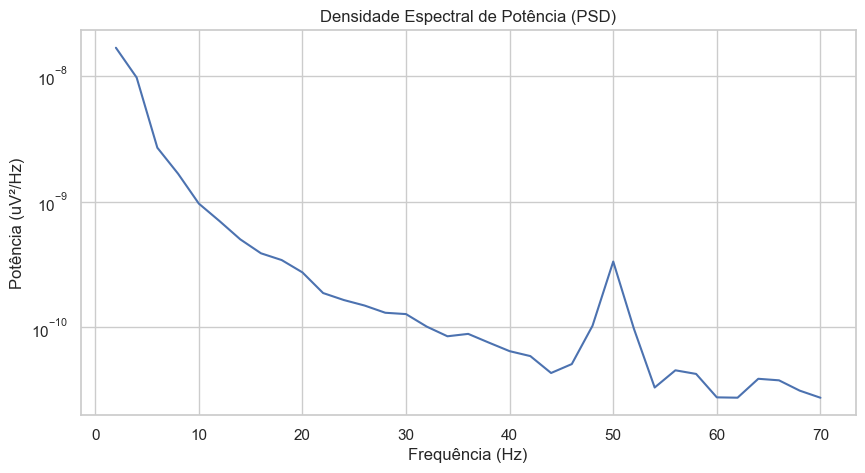

In [ ]:
## ⚡ Power Spectral Density (PSD) Analysis

# Compute Power Spectral Density using Welch’s method
psds, freqs = PSD_FUNC(clean_signal.get_data(), sfreq=clean_signal.info['sfreq'], fmin=0.5, fmax=70)

# Average and plot
plt.figure(figsize=(10,5))
plt.semilogy(freqs, np.mean(psds, axis=0))
plt.title('Densidade Espectral de Potência (PSD)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (uV²/Hz)')
plt.grid(True)
plt.show()


Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


Delta  ( 0.5- 4.0 Hz): 1.33e-08 µV²/Hz
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


Theta  ( 4.0- 8.0 Hz): 4.69e-09 µV²/Hz
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Alpha  ( 8.0-13.0 Hz): 1.11e-09 µV²/Hz
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Beta   (13.0-30.0 Hz): 2.51e-10 µV²/Hz
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Gamma  (30.0-70.0 Hz): 7.31e-11 µV²/Hz
Gamma  (30.0-70.0 Hz): 7.31e-11 µV²/Hz


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


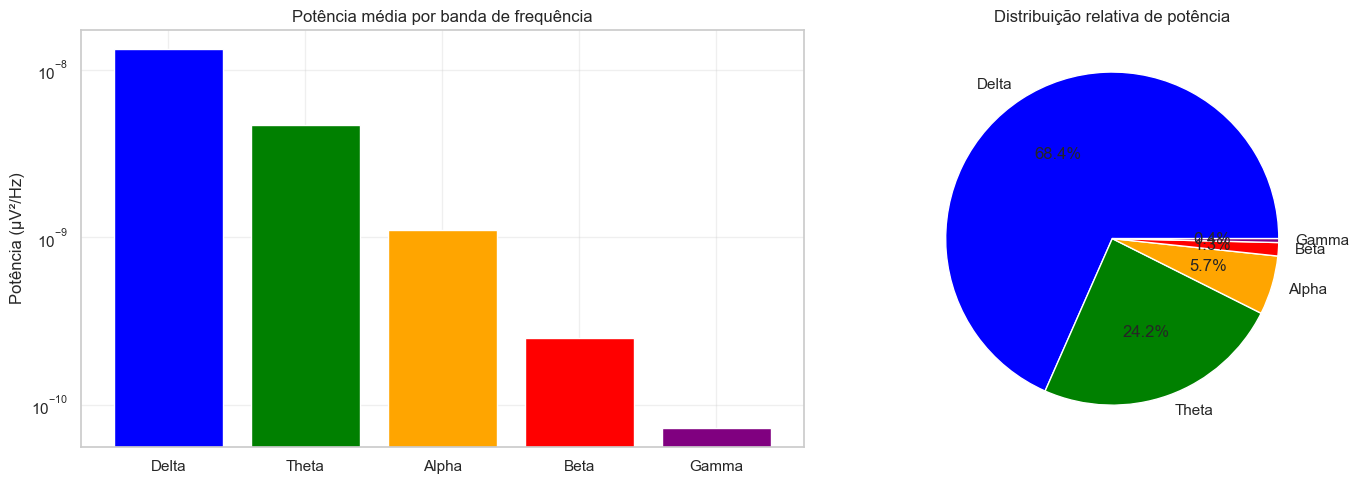


 Nota: Em EEG epiléptico, espera-se:
   - Aumento de Delta (ondas lentas)
   - Aumento de Gamma (atividade rápida anormal)
   - Possível redução de Alpha (ritmo de fundo desorganizado)


In [ ]:
## 🔍 Frequency Band Analysis 

# Bandas completas para análise de epilepsia
bands = {
    'Delta': (0.5, 4), 
    'Theta': (4, 8), 
    'Alpha': (8, 13), 
    'Beta': (13, 30),
    'Gamma': (30, 70) 
}

band_powers = {}
for band, (low, high) in bands.items():
    psd, freqs = PSD_FUNC(clean_signal.get_data(), 
                          sfreq=clean_signal.info['sfreq'], 
                          fmin=low, fmax=high)
    band_powers[band] = np.mean(psd)
    print(f"{band:6s} ({low:4.1f}-{high:4.1f} Hz): {band_powers[band]:.2e} µV²/Hz")

# Plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de barras
ax1.bar(band_powers.keys(), band_powers.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
ax1.set_title('Potência média por banda de frequência')
ax1.set_ylabel('Potência (µV²/Hz)')
ax1.set_yscale('log')  
ax1.grid(True, alpha=0.3)

# Gráfico de pizza (proporções relativas)
total_power = sum(band_powers.values())
proportions = [p/total_power*100 for p in band_powers.values()]
ax2.pie(proportions, labels=band_powers.keys(), autopct='%1.1f%%',
        colors=['blue', 'green', 'orange', 'red', 'purple'])
ax2.set_title('Distribuição relativa de potência')

plt.tight_layout()
plt.show()

print(f"\n Nota: Em EEG epiléptico, espera-se:")
print(f"   - Aumento de Delta (ondas lentas)")
print(f"   - Aumento de Gamma (atividade rápida anormal)")
print(f"   - Possível redução de Alpha (ritmo de fundo desorganizado)")

Mostrando as bandas filtradas para o canal: EEG FP1


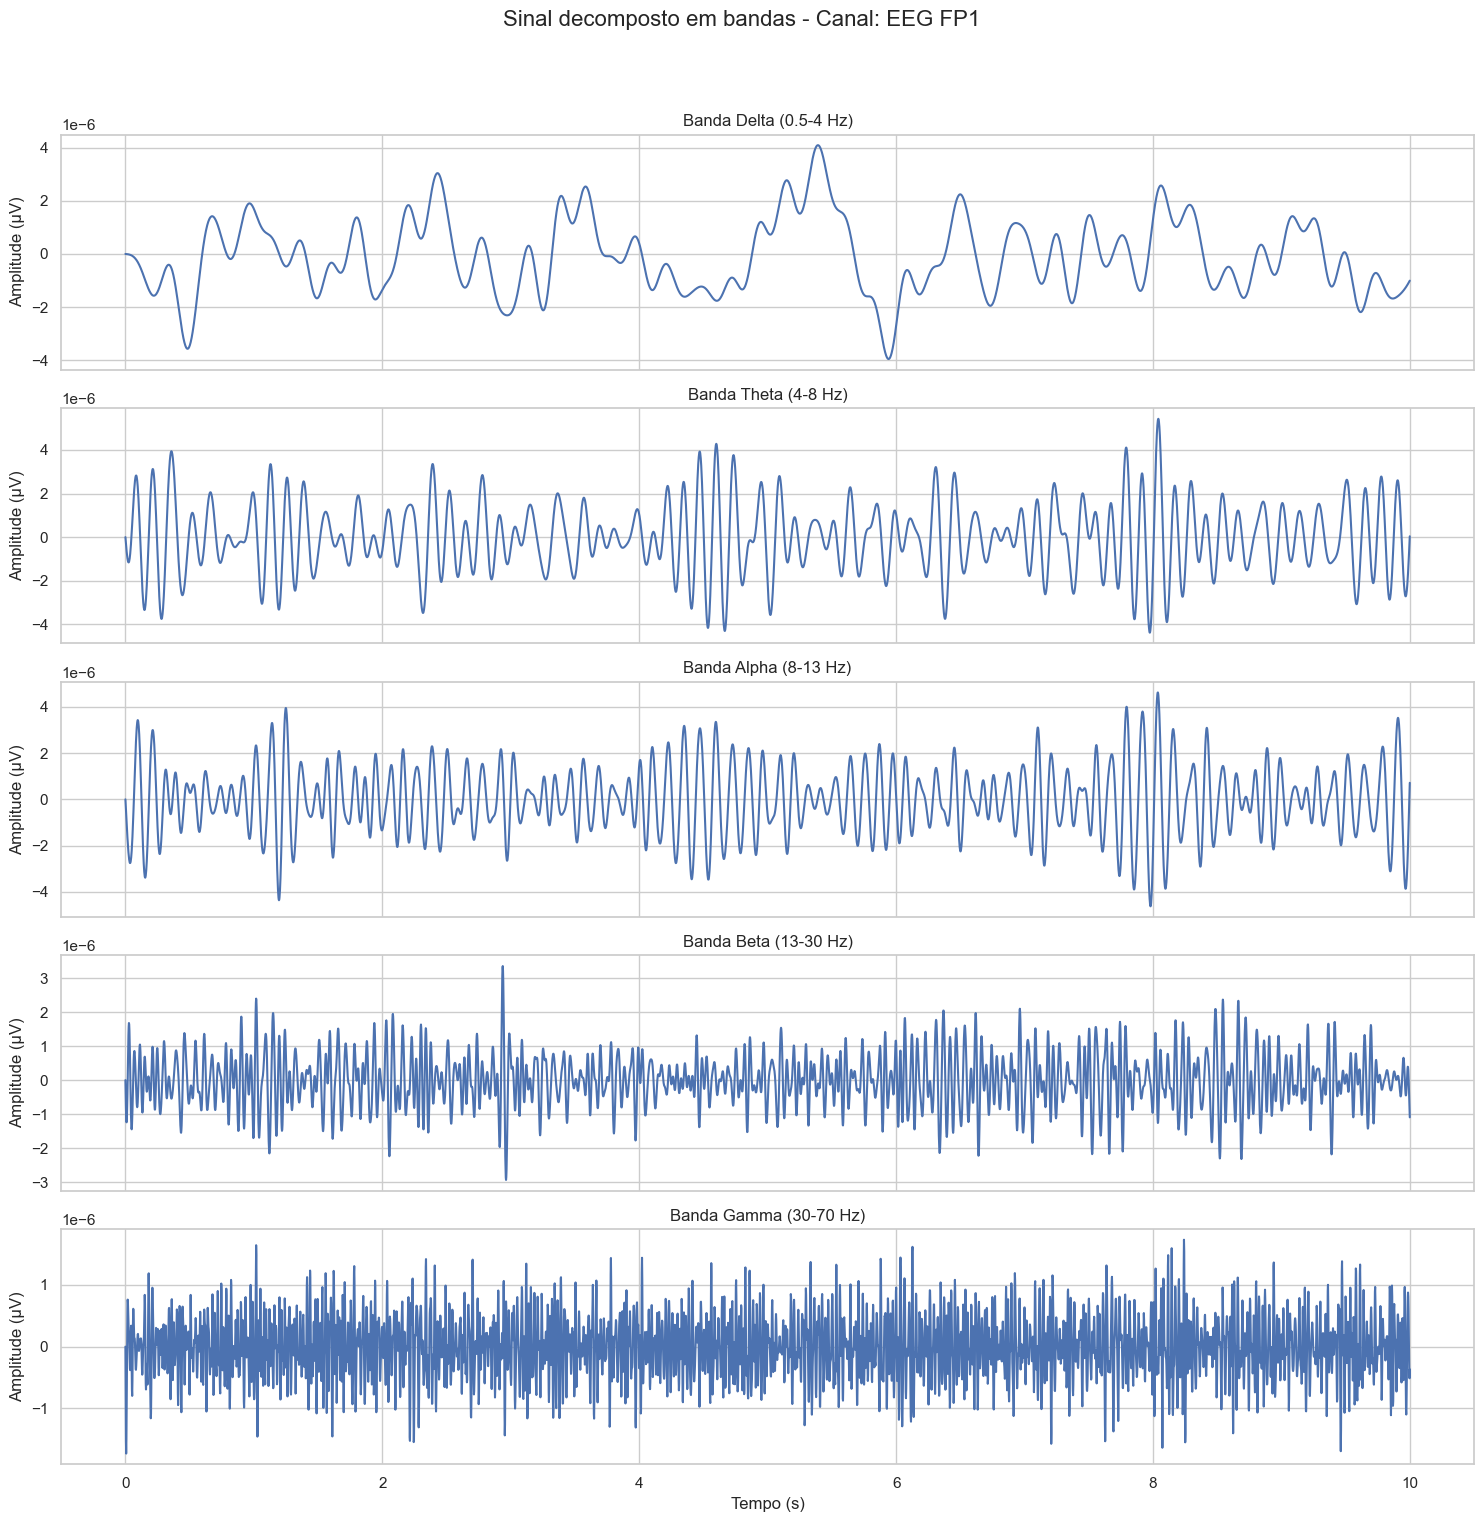

In [ ]:
import matplotlib.pyplot as plt
import mne

# Fonte de dados: sinal já limpo (após filtro + ICA)
data_source = clean_signal

# 1) Dados e times
data, times = data_source.get_data(return_times=True)
sfreq = data_source.info['sfreq']

# 2) Escolhe um canal para visualizar (ex.: primeiro canal)
channel_index = 0
channel_name = data_source.info['ch_names'][channel_index]
data_ch = data[channel_index]

print(f"Mostrando as bandas filtradas para o canal: {channel_name}")

# 3) Define as bandas incluindo Gamma
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 70)
}

# 4) Cria subplots dinamicamente de acordo com o número de bandas
n_bands = len(bands)
fig, axes = plt.subplots(n_bands, 1, figsize=(15, max(10, 2 * n_bands + 6)), sharex=True)
if n_bands == 1:
    axes = [axes]

# 5) Limite de tempo para visualização (ex.: 10s)
time_limit_sec = 10
sample_limit = int(time_limit_sec * sfreq)

# 6) Itera, filtra e plota cada banda
for ax, (band, (low, high)) in zip(axes, bands.items()):
    # Filtra o array do canal diretamente (mne.filter.filter_data)
    filtered_data = mne.filter.filter_data(data_ch, sfreq, l_freq=low, h_freq=high,
                                           fir_design='firwin', verbose=False)
    ax.plot(times[:sample_limit], filtered_data[:sample_limit])
    ax.set_title(f'Banda {band} ({low}-{high} Hz)')
    ax.set_ylabel('Amplitude (µV)')

axes[-1].set_xlabel('Tempo (s)')
plt.suptitle(f'Sinal decomposto em bandas - Canal: {channel_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()